The purpose of this notebook is to develop a script that can take household-level time-stamped numerical data (e.g. smart meter data, but could be anythig like temperature data) and normalise this, then chunk it into sequences of specified length (default 24 hours), with a sequence on each row, and convert the data into sequences of characters of integers with minimum 0 to a specified maximum (default 20) where the max corresponds to the max value in the sequence i.e. 1 in the normalised data.

In [1]:
# let's start by importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [10]:
# forgot to specify inline for matplotlib
%matplotlib inline

In [4]:
# now let's load some test data from a csv file
data = pd.read_csv('/Users/eoghan/repos/makemore/data/home62_hall705_sensor1662c1666_electric-mains_electric-combined.csv')


In [6]:
# this is data for a single sensor, in this case electicity usage for a single house. Let's visualise it using matplotlib
# first what are the columns in the data
print(data.columns)

Index(['2016-08-26 09:00:00', '117'], dtype='object')


In [7]:
# the data doesnt have column names, so we need to specify them, there's a timestamp and a value
data.columns = ['timestamp', 'value']

In [8]:
data.head()

,timestamp,value
0,2016-08-26 10:00:00,200
1,2016-08-26 11:00:00,325
2,2016-08-26 12:00:00,566
3,2016-08-26 13:00:00,578
4,2016-08-26 14:00:00,591


In [12]:
len(data)

15496

In [13]:
# now let's use pandas to produce some basic statistics
data.describe()

,value
count,15496.000000
mean,229.379904
std,178.424085
min,0.000000
25%,131.000000
50%,156.000000
75%,248.000000
max,2366.000000


In [14]:
data.dtypes

timestamp    object
value         int64
dtype: object

In [15]:
# let's convert the timestamp to a datetime object
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [16]:
data.timestamp.min(), data.timestamp.max()

(Timestamp('2016-08-26 10:00:00'), Timestamp('2018-06-30 23:00:00'))

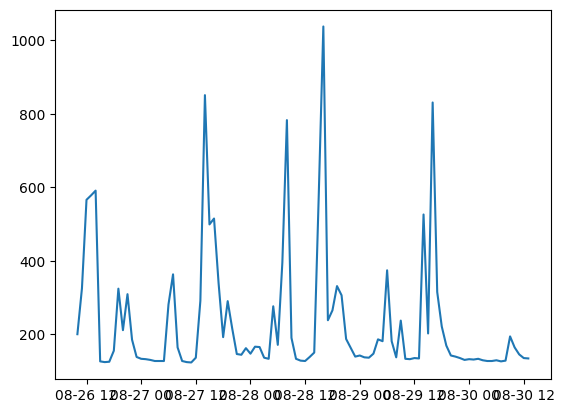

In [17]:
# now let's plot the first 100 values
plt.plot(data['timestamp'][:100], data['value'][:100])

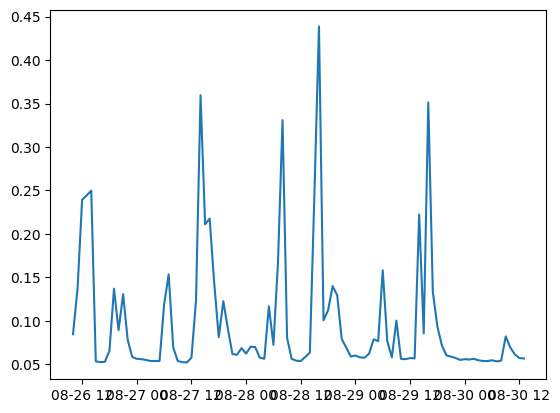

In [18]:
# and now we are ready to start implementing the goal of the notebook which is to develop code that can take household-level time-stamped numerical data (e.g. smart meter data, but could be anythig like temperature data) and normalise this, then chunk it into sequences of specified length (default 24 hours), with a sequence on each row, and convert the data into sequences of characters of integers with minimum 0 to a specified maximum (default 20) where the max corresponds to the max value in the sequence i.e. 1 in the normalised data.
# so first we want to normalise the data so that it lies between 0 and 1 using the following formula:
# x = (x - min(x)) / (max(x) - min(x))
data['normalised'] = (data['value'] - data['value'].min()) / (data['value'].max() - data['value'].min())
# and let's plot the first 100 values to see if they look normliased
plt.plot(data['timestamp'][:100], data['normalised'][:100])

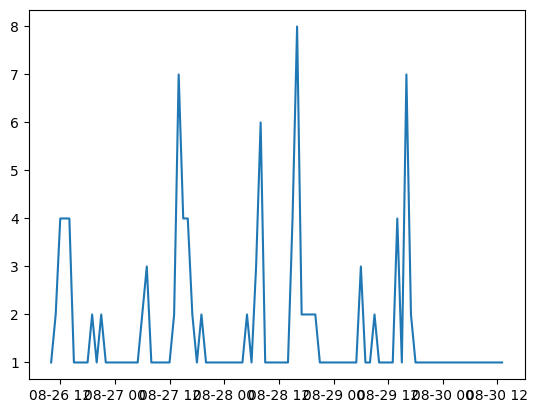

In [19]:
# and now we want to convert the normalised data into sequences of characters of integers with minimum 0 to a specified maximum (default 20) where the max corresponds to the max value in the sequence i.e. 1 in the normalised data.
# so first let's convert the normalised data into integers
data['int'] = (data['normalised'] * 20).astype(int)
# and again let's plot the first 100 values to see if they look normliased
plt.plot(data['timestamp'][:100], data['int'][:100])

In [20]:
# and now we want to create a new file which will be a text file with a sequence of characters on each row, 
# each row should be a day of data. each row should start with the the character corresponding to the first timestamp in the day, let's assume this corresponds to 00:00:00
# the data is hourly resolution, so there should be 24 characters in each row, there may be missing data however, and so we need a special character to represent missing data, that will be <M>.
# so let's start by filling in missing data with <M>
# first we need to resample the data to hourly resolution so that missing rowa are created
data = data.set_index('timestamp').resample('H').mean()
# are there any missing rows?
data.isnull().sum()

/var/folders/7q/98fsk0b17kd8f7f35ly21m3m0000gq/T/ipykernel_433/248698164.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data = data.set_index('timestamp').resample('H').mean()


value         670
normalised    670
int           670
dtype: int64

In [21]:
# let's check what these missing rows look like
data[data.isnull().any(axis=1)].head()

,value,normalised,int
timestamp,,,
2016-10-20 22:00:00,NaN,NaN,NaN
2016-10-20 23:00:00,NaN,NaN,NaN
2016-10-21 00:00:00,NaN,NaN,NaN
2016-10-21 01:00:00,NaN,NaN,NaN
2016-10-21 02:00:00,NaN,NaN,NaN


In [22]:
# what are the start and end times of the data?
data.index.min(), data.index.max()


(Timestamp('2016-08-26 10:00:00'), Timestamp('2018-06-30 23:00:00'))

In [24]:
# the start time is not 00:00:00, so we need to fill in the missing rows with <M>
# so first create a row with index time stamp (Timestamp('2016-08-26 00:00:00')) 
# and value NaN nd then append this to the data
new_row = pd.DataFrame({'value': [np.nan]}, index=[pd.Timestamp('2016-08-26 00:00:00')])
data = pd.concat([data, new_row])
# and now sort the data by index
data = data.sort_index()
# then resample the data so that the missing rows are filled with NaN
data = data.resample('H').mean()
# and then check the number of missing rows which should be about 9 more than previous
data.isnull().sum()

/var/folders/7q/98fsk0b17kd8f7f35ly21m3m0000gq/T/ipykernel_433/77966068.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data = data.resample('H').mean()


value         680
normalised    680
int           680
dtype: int64

In [25]:
data.head(n=30)

,value,normalised,int
2016-08-26 00:00:00,NaN,NaN,NaN
2016-08-26 01:00:00,NaN,NaN,NaN
2016-08-26 02:00:00,NaN,NaN,NaN
2016-08-26 03:00:00,NaN,NaN,NaN
2016-08-26 04:00:00,NaN,NaN,NaN
2016-08-26 05:00:00,NaN,NaN,NaN
2016-08-26 06:00:00,NaN,NaN,NaN
2016-08-26 07:00:00,NaN,NaN,NaN
2016-08-26 08:00:00,NaN,NaN,NaN
2016-08-26 09:00:00,NaN,NaN,NaN


In [30]:
data.dtypes

value         float64
normalised    float64
int           float64
dtype: object

In [31]:
# the int column is not an integer dtype so we need to convert it
data['char'] = data['int'].fillna('<M>')
data.head(n=30)

,value,normalised,int,char
2016-08-26 00:00:00,NaN,NaN,NaN,<M>
2016-08-26 01:00:00,NaN,NaN,NaN,<M>
2016-08-26 02:00:00,NaN,NaN,NaN,<M>
2016-08-26 03:00:00,NaN,NaN,NaN,<M>
2016-08-26 04:00:00,NaN,NaN,NaN,<M>
2016-08-26 05:00:00,NaN,NaN,NaN,<M>
2016-08-26 06:00:00,NaN,NaN,NaN,<M>
2016-08-26 07:00:00,NaN,NaN,NaN,<M>
2016-08-26 08:00:00,NaN,NaN,NaN,<M>
2016-08-26 09:00:00,NaN,NaN,NaN,<M>


In [32]:
data.dtypes

value         float64
normalised    float64
int           float64
char           object
dtype: object

In [33]:
data['char'] = data['char'].astype(str)

In [34]:
data.head(n=30)

,value,normalised,int,char
2016-08-26 00:00:00,NaN,NaN,NaN,<M>
2016-08-26 01:00:00,NaN,NaN,NaN,<M>
2016-08-26 02:00:00,NaN,NaN,NaN,<M>
2016-08-26 03:00:00,NaN,NaN,NaN,<M>
2016-08-26 04:00:00,NaN,NaN,NaN,<M>
2016-08-26 05:00:00,NaN,NaN,NaN,<M>
2016-08-26 06:00:00,NaN,NaN,NaN,<M>
2016-08-26 07:00:00,NaN,NaN,NaN,<M>
2016-08-26 08:00:00,NaN,NaN,NaN,<M>
2016-08-26 09:00:00,NaN,NaN,NaN,<M>


In [36]:
# great. so now we have the necessary data to write to a text file. the data is in the char columns,
# and we want to write this to a text file with a sequence of characters on each row, with the starting character being the character with a time stamp 00:00:00 each dat
# so first let's create a new column with the date of the timestamp
data['date'] = data.index.date
# and then we can use this to group the data by date, let's create a new data object

data2 = data.groupby('date')['char'].apply(lambda x: ' '.join(x)).reset_index()
# let's check the first few rows
data2.head()



,date,char
0,2016-08-26,<M> <M> <M> <M> <M> <M> <M> <M> <M> <M> 1.0 2....
1,2016-08-27,1.0 1.0 1.0 1.0 1.0 1.0 2.0 3.0 1.0 1.0 1.0 1....
2,2016-08-28,1.0 1.0 1.0 1.0 1.0 2.0 1.0 3.0 6.0 1.0 1.0 1....
3,2016-08-29,1.0 1.0 1.0 1.0 1.0 1.0 3.0 1.0 1.0 2.0 1.0 1....
4,2016-08-30,1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1....


In [37]:
# and now let's create the text file, let's call it data.txt
data2.to_csv('/Users/eoghan/repos/makemore/data/data.txt', columns=['char'], header=False, index=False)
# let's check the file
!head /Users/eoghan/repos/makemore/data/data.txt

<M> <M> <M> <M> <M> <M> <M> <M> <M> <M> 1.0 2.0 4.0 4.0 4.0 1.0 1.0 1.0 1.0 2.0 1.0 2.0 1.0 1.0
1.0 1.0 1.0 1.0 1.0 1.0 2.0 3.0 1.0 1.0 1.0 1.0 1.0 2.0 7.0 4.0 4.0 2.0 1.0 2.0 1.0 1.0 1.0 1.0
1.0 1.0 1.0 1.0 1.0 2.0 1.0 3.0 6.0 1.0 1.0 1.0 1.0 1.0 1.0 4.0 8.0 2.0 2.0 2.0 2.0 1.0 1.0 1.0
1.0 1.0 1.0 1.0 1.0 1.0 3.0 1.0 1.0 2.0 1.0 1.0 1.0 1.0 4.0 1.0 7.0 2.0 1.0 1.0 1.0 1.0 1.0 1.0
1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.0 1.0 0.0 0.0 0.0
1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.0 0.0 1.0 0.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0 0.0 1.0 1.0 1.0 1.0 1.0 1.0
